In [1]:
# Core libraries
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.multioutput import MultiOutputRegressor
# Evaluation
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
# Utilities
import joblib
import warnings
warnings.filterwarnings("ignore")


np.random.seed(42)


In [2]:
df = pd.read_csv("../data/cars_data.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,I10,2017,7495.0,Manual,11630,Petrol,145,60.1,1.0,hyundi
1,Polo,2017,10989.0,Manual,9200,Petrol,145,58.9,1.0,volkswagen
2,2 Series,2019,27990.0,Semi-Auto,1614,Diesel,145,49.6,2.0,BMW
3,Yeti Outdoor,2017,12495.0,Manual,30960,Diesel,150,62.8,2.0,skoda
4,Fiesta,2017,7999.0,Manual,19353,Petrol,125,54.3,1.2,ford


In [3]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,1999.000000,1976.000000,1999.000000,1999.000000,1930.000000,1999.000000
mean,2017.108554,16983.185223,23354.633317,119.994997,55.090311,1.678089
std,2.077749,10218.769393,21437.891553,61.984410,18.184762,0.561039
min,1998.000000,1490.000000,1.000000,0.000000,22.600000,0.000000
25%,2016.000000,10198.750000,7834.500000,125.000000,46.300000,1.300000
50%,2017.000000,14492.000000,17727.000000,145.000000,54.300000,1.600000
75%,2019.000000,20991.250000,32749.000000,145.000000,62.800000,2.000000
max,2020.000000,114199.000000,168017.000000,570.000000,470.800000,5.500000


In [4]:
df.isna().sum()

model            0
year             0
price           23
transmission     0
mileage          0
fuelType        85
tax              0
mpg             69
engineSize       0
Manufacturer     0
dtype: int64

In [5]:
# 2. Duplicate rows
duplicates = df.sample(10)
df = pd.concat([df, duplicates], ignore_index=True)

In [6]:
df.duplicated().sum()

np.int64(10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         2009 non-null   object 
 1   year          2009 non-null   int64  
 2   price         1986 non-null   float64
 3   transmission  2009 non-null   object 
 4   mileage       2009 non-null   int64  
 5   fuelType      1924 non-null   object 
 6   tax           2009 non-null   int64  
 7   mpg           1940 non-null   float64
 8   engineSize    2009 non-null   float64
 9   Manufacturer  2009 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 157.1+ KB


In [8]:
df = df.dropna(subset=["price"])


In [9]:
df.isna().sum()

model            0
year             0
price            0
transmission     0
mileage          0
fuelType        62
tax              0
mpg             46
engineSize       0
Manufacturer     0
dtype: int64

In [10]:
# Handle numeric missing values
df["mpg"].fillna(df["mpg"].median(), inplace=True)


In [11]:
# Handle categorical missing values
df["fuelType"].fillna(df["fuelType"].mode()[0], inplace=True)


In [12]:
#removing the duplicates
df = df.drop_duplicates()


In [13]:
df.duplicated().sum()


np.int64(0)

In [14]:
df.isna().sum()


model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Manufacturer    0
dtype: int64

In [15]:
# Car Age
current_year = df["year"].max()
df["car_age"] = current_year - df["year"]


In [16]:
# Log Mileage & Log price
df["log_mileage"] = np.log1p(df["mileage"])
df["log_price"] = np.log1p(df["price"])


In [17]:
# Drop Unused Columns --Target will be log_price
df = df.drop(columns=["price", "year", "mileage"])


In [18]:
# creating the cat and num cols
cat_cols = df.select_dtypes(include="object").columns
num_cols = df.select_dtypes(include=["int64", "float64"]).columns



In [19]:
cat_cols = cat_cols.drop("log_price", errors="ignore")


In [20]:
# One-Hot Encoding
df_encoded = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True
)


In [21]:
# Train / Test Split
X = df_encoded.drop("log_price", axis=1)
y = df_encoded["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [22]:
# Scaling (NUMERIC ONLY)
scale_cols = ["tax", "mpg", "engineSize", "car_age", "log_mileage"]

scaler = StandardScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])


In [23]:
# Train Models
lr = LinearRegression()
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42
)
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42)

In [32]:
# Evaluation
def evaluate(model, name):
    pred_log = model.predict(X_test)
    pred = np.expm1(pred_log)
    y_real = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_real, pred))
    r2 = r2_score(y_real, pred)

    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.3f}")

evaluate(lr, "Linear Regression")
evaluate(rf, "Random Forest")
evaluate(gb, "Gradient Boosting")


Linear Regression → RMSE: 3754.08, R²: 0.836
Random Forest → RMSE: 4203.79, R²: 0.794
Gradient Boosting → RMSE: 3966.32, R²: 0.817


In [25]:
joblib.dump(lr, "../models/linear_regression.pkl")
joblib.dump(rf, "../models/random_forest.pkl")
joblib.dump(gb, "../models/gradient_boosting.pkl")

['../models/gradient_boosting.pkl']

In [26]:
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

In [34]:
# Predict (log scale)
y_pred_log = lr.predict(X_test)

# Convert back to real price
y_pred = np.expm1(y_pred_log)

# Convert actual y_test back to real price
y_actual = np.expm1(y_test)


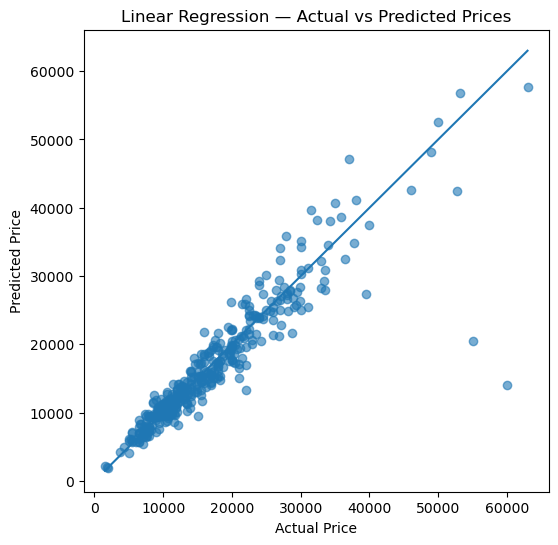

In [36]:
plt.figure(figsize=(6, 6))

plt.scatter(y_actual, y_pred, alpha=0.6)

# Perfect prediction line
plt.plot(
    [y_actual.min(), y_actual.max()],
    [y_actual.min(), y_actual.max()]
)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression — Actual vs Predicted Prices")
plt.savefig("../plots/linear_reg_actual_vs_pred.png", dpi=300)
plt.show()

In [38]:
X.columns

Index(['tax', 'mpg', 'engineSize', 'car_age', 'log_mileage', 'model_ 2 Series',
       'model_ 3 Series', 'model_ 4 Series', 'model_ 5 Series',
       'model_ 6 Series',
       ...
       'fuelType_Other', 'fuelType_Petrol', 'Manufacturer_BMW',
       'Manufacturer_ford', 'Manufacturer_hyundi', 'Manufacturer_merc',
       'Manufacturer_skoda', 'Manufacturer_toyota', 'Manufacturer_vauxhall',
       'Manufacturer_volkswagen'],
      dtype='object', length=153)

In [39]:
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")

['feature_columns.pkl']